In [21]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [15]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')

In [22]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


In [23]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [16]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

In [5]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 12})

# Load Tracks

In [63]:
class_thresh_base = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}

excl_thresh_base = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 50,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes

test_names = [
    'base', 'lower_conv_level', 'higher_conv_level', 
    'four_levels', 'no_steiner', 'lower_ref_thresh',
    'higher_shear_thresh', 'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'linear_50', 'linear_25', 'combined']

tracks_dir = [
    'base', 'lower_conv_level', 'higher_conv_level', 
    'four_levels', 'no_steiner', 'lower_ref_thresh',
    'base', 'base', 
    'base', 'base', 'base', 
    'base', 'base', 'base', 'combined']

[
    class_thresh_S4, class_thresh_RV4, 
    class_thresh_T15, class_thresh_SO15] = [
    copy.deepcopy(class_thresh_base) for i in range(4)]

class_thresh_S4['SHEAR_MAG'] = 4
class_thresh_RV4['REL_VEL_MAG'] = 4
class_thresh_T15['ANGLE_BUFFER'] = 15
class_thresh_SO15['OFFSET_MAG'] = 15000

class_thresh_comb = {
    'OFFSET_MAG': 12500,
    'SHEAR_MAG': 3,
    'VEL_MAG': 5,
    'REL_VEL_MAG': 3,
    'ANGLE_BUFFER': 15}

class_threshes = [
    class_thresh_base, class_thresh_base, class_thresh_base, 
    class_thresh_base, class_thresh_base, class_thresh_base,
    class_thresh_S4, class_thresh_RV4, 
    class_thresh_T15, class_thresh_SO15, class_thresh_base, 
    class_thresh_base, class_thresh_base, class_thresh_base,
    class_thresh_comb]

[
    excl_thresh_B05, excl_thresh_A2000, 
    excl_thresh_L50, excl_thresh_L25] = [
    copy.deepcopy(excl_thresh_base) for i in range(4)]

excl_thresh_B05['BORD_THRESH'] = 0.0005
excl_thresh_A2000['SMALL_AREA'] = 2000
excl_thresh_L50['MAJOR_AXIS_LENGTH'] = 50
excl_thresh_L25['MAJOR_AXIS_LENGTH'] = 25

excl_thresh_comb = {
    'SMALL_AREA': 2000,
    'LARGE_AREA': 50000,
    'BORD_THRESH': 0.001,
    'MAJOR_AXIS_LENGTH': 25,
    'AXIS_RATIO': 2,
    'DURATION': 30}

excl_threshes = [
    excl_thresh_base, excl_thresh_base, excl_thresh_base, 
    excl_thresh_base, excl_thresh_base, excl_thresh_base,
    excl_thresh_base, excl_thresh_base,
    excl_thresh_base, excl_thresh_base, excl_thresh_B05, 
    excl_thresh_A2000, excl_thresh_L50, excl_thresh_L25,
    excl_thresh_comb]

non_linear_conds = [
    False, False, False, False, False, False, False, False,
    False, False, False, False, True, True, False]

get_exclusions = [
    False, False, False, False, False, False, True, True,
    True, True, True, True, True, True, False]

# for i in range(len(test_names)):
for i in [5]:
    
    print('Getting classes for test:{}.'.format(test_names[i]))
    class_df = cl.get_counts(
        base_dir='/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/',
        get_exclusions=get_exclusions[i], tracks_dir=tracks_dir[i], 
        class_thresh=class_threshes[i], excl_thresh=excl_threshes[i],
        non_linear=non_linear_conds[i])

    out_file_name = save_dir + '{}_classes.pkl'.format(test_names[i])
    with open(out_file_name, 'wb') as f:
        pickle.dump(class_df, f)

Getting classes for test:lower_ref_thresh.
Processing year 1998
Adding Pope monsoon regime.
Processing year 1999
Adding Pope monsoon regime.
Processing year 2001
Adding Pope monsoon regime.
Processing year 2002
Adding Pope monsoon regime.
Processing year 2003
Adding Pope monsoon regime.
Processing year 2004
Adding Pope monsoon regime.
Processing year 2005
Adding Pope monsoon regime.
Processing year 2006
Adding Pope monsoon regime.
Processing year 2009
Adding Pope monsoon regime.
Processing year 2010
Adding Pope monsoon regime.
Processing year 2011
Adding Pope monsoon regime.
Processing year 2012
Adding Pope monsoon regime.
Processing year 2013
Adding Pope monsoon regime.
Processing year 2014
Adding Pope monsoon regime.
Processing year 2015
Adding Pope monsoon regime.


In [64]:
sen_dfs = cl.plot_all()

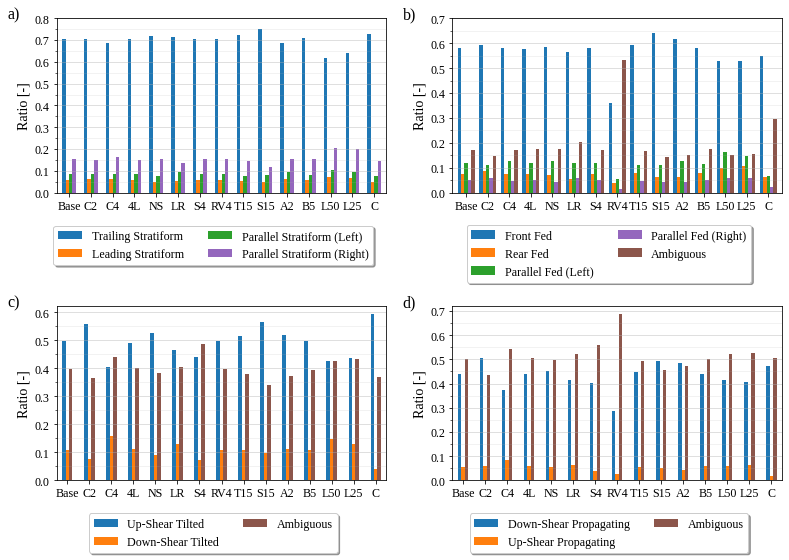

In [65]:
cl.plot_sensitivities(sen_dfs)

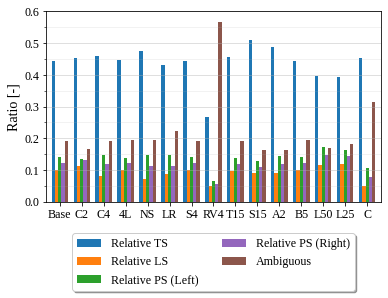

In [68]:
can_sensitivity_df = cl.category_breakdown()

In [69]:
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
class_path = base_dir + 'TINT_tracks/'
class_path += 'base_classes.pkl'

with open(class_path, 'rb') as f:
    class_df = pickle.load(f)

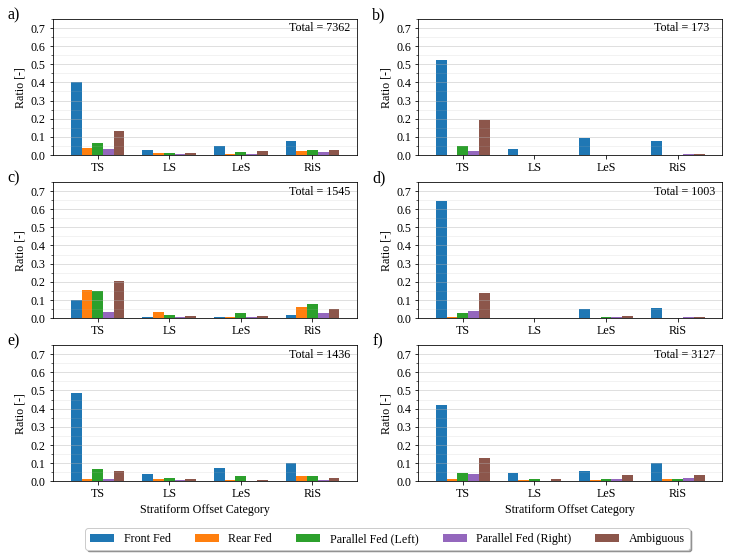

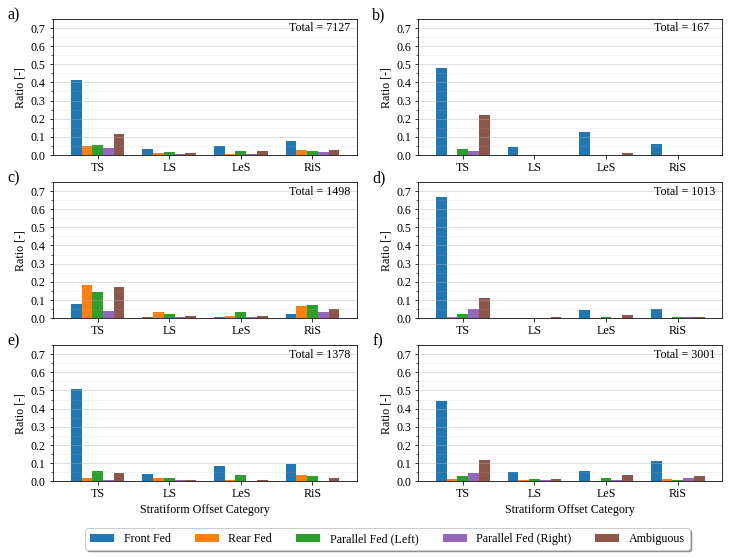

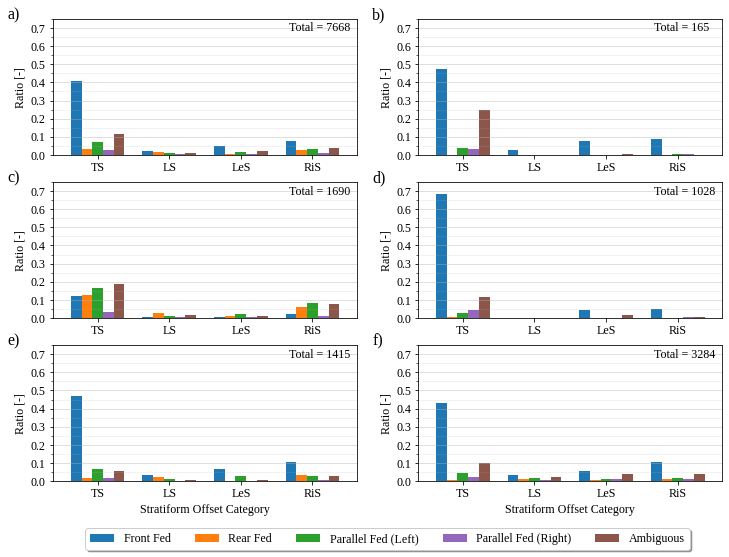

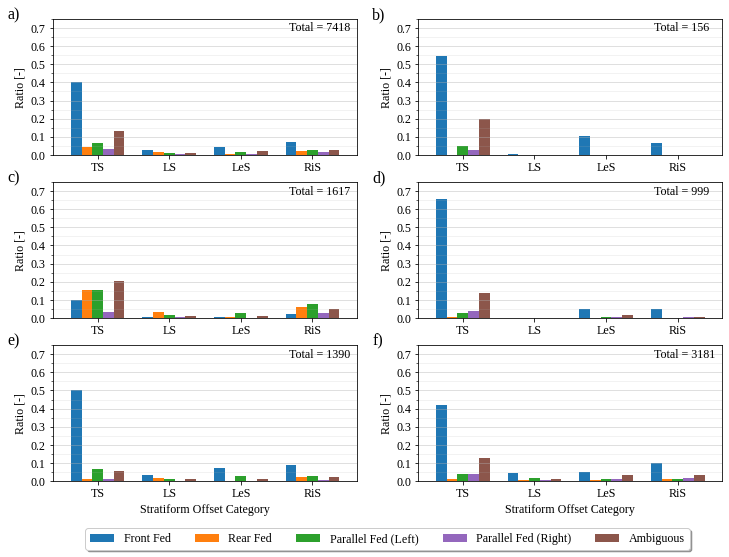

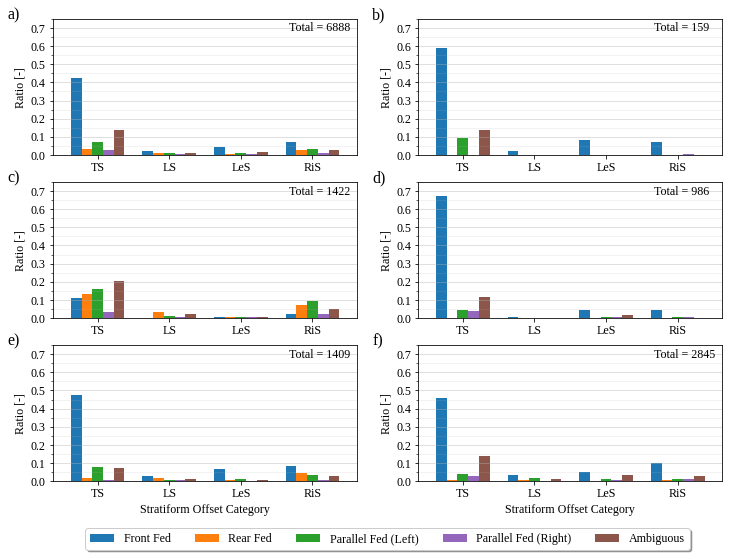

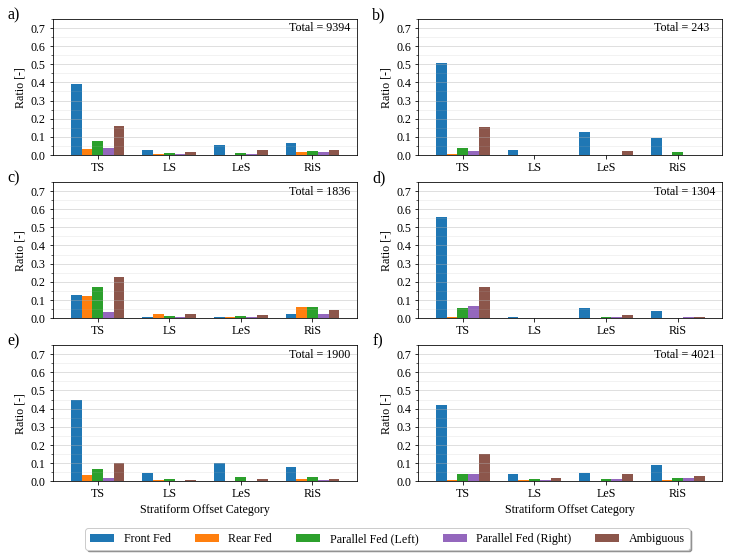

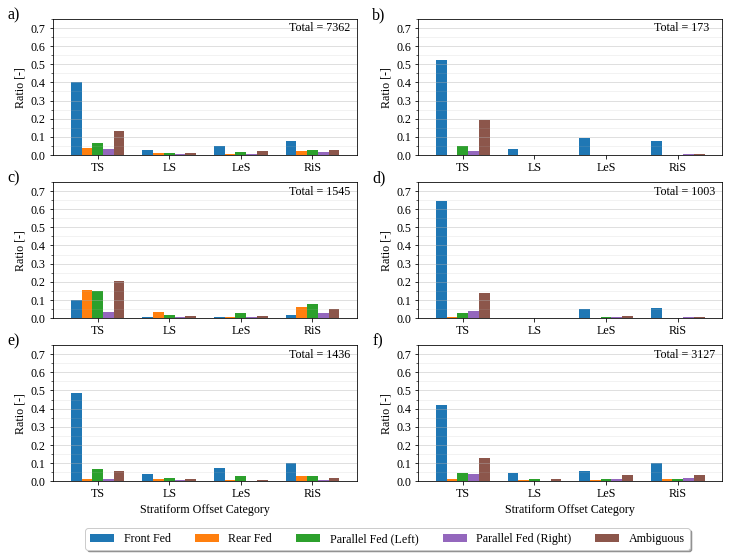

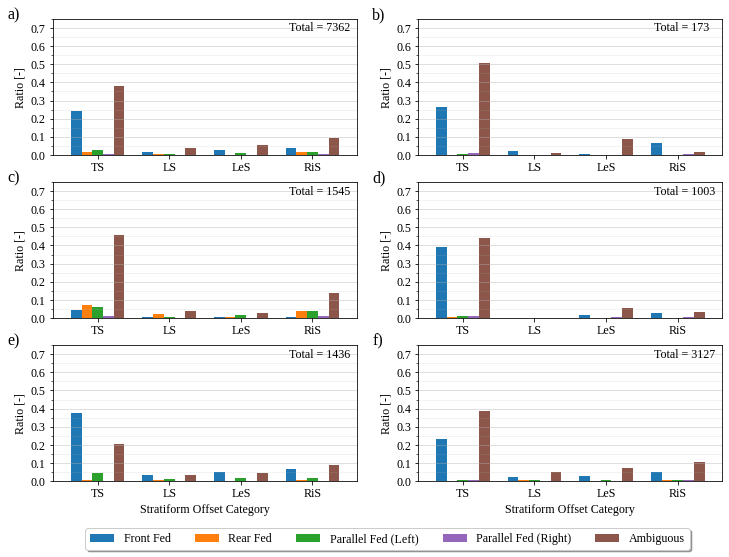

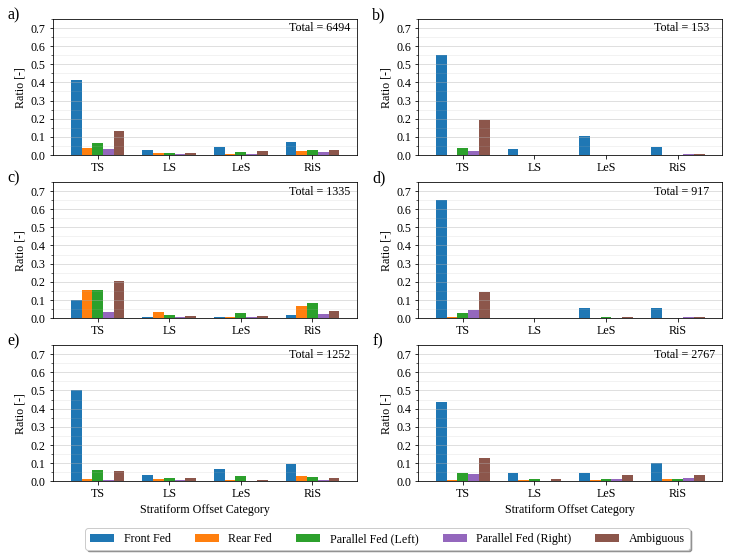

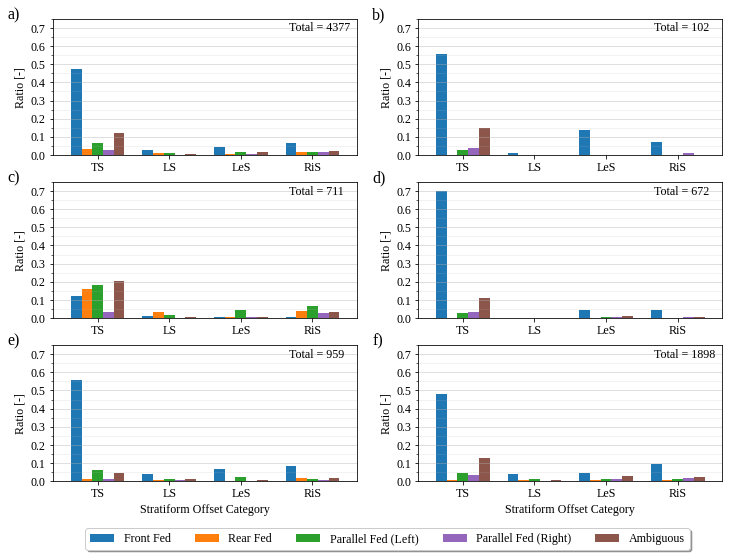

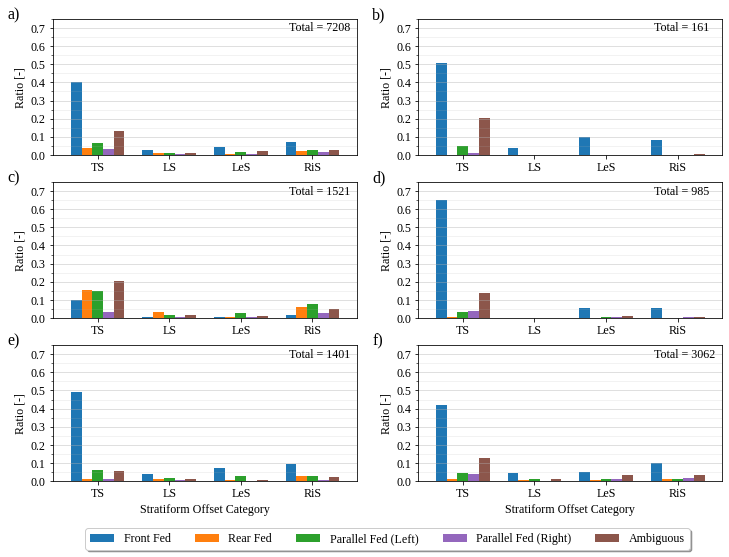

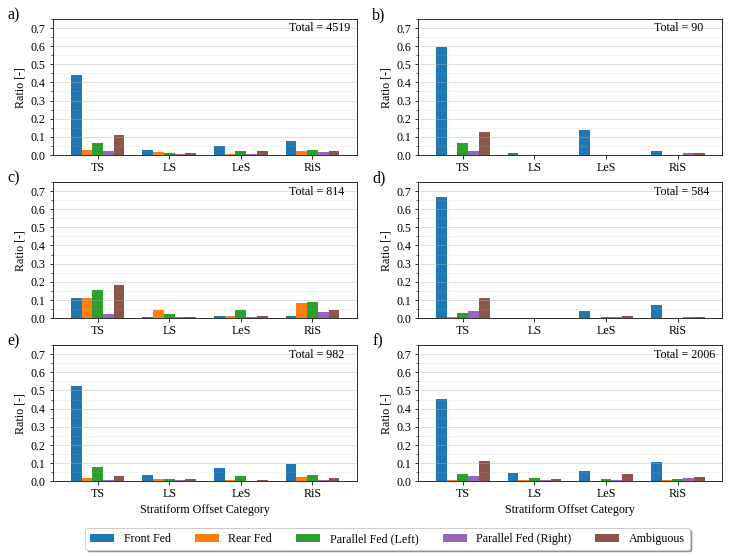

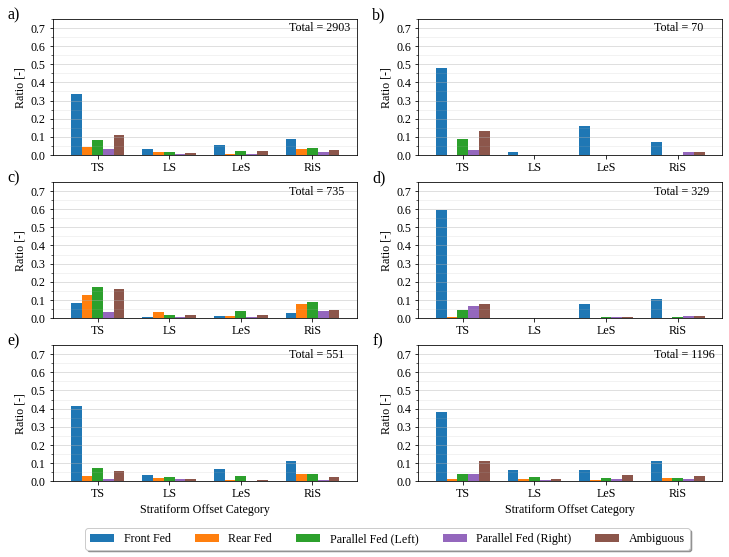

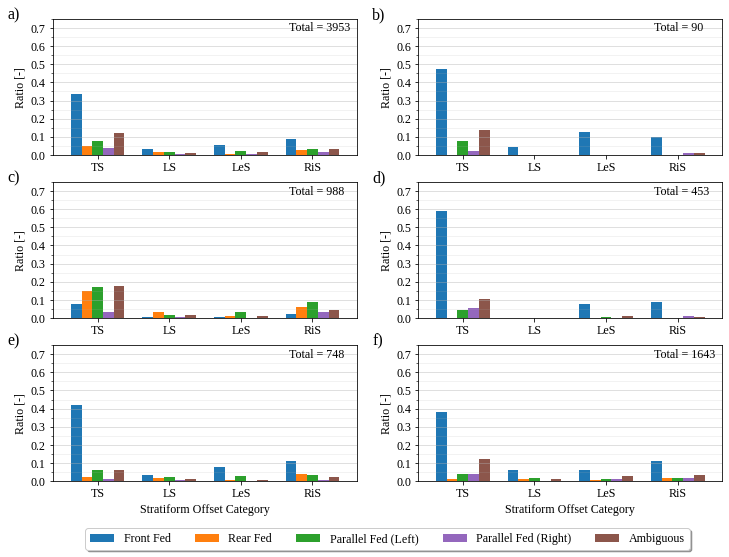

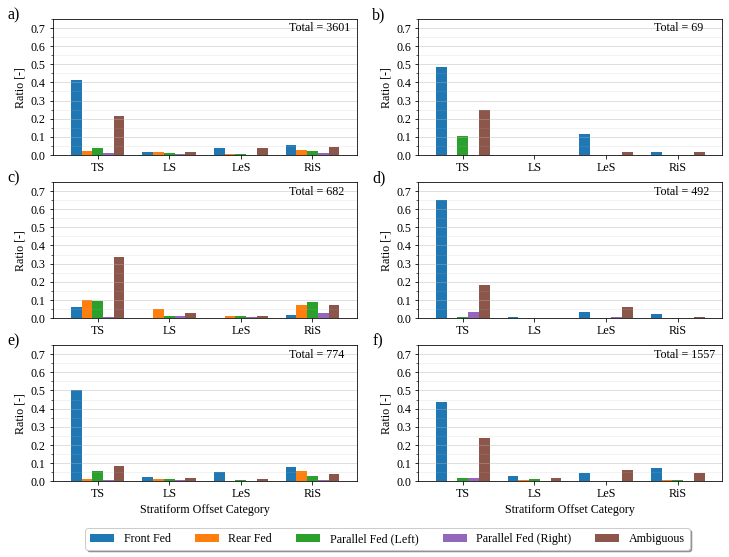

In [73]:
test_names = [
    'base', 'lower_conv_level', 'higher_conv_level', 'four_levels',
    'no_steiner', 'lower_ref_thresh', 'higher_shear_thresh', 'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'linear_50', 'linear_25', 'combined']

for i in range(len(test_names)):
# for i in [0]:

    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/'
    class_path += '{}_classes.pkl'.format(test_names[i])

    with open(class_path, 'rb') as f:
        class_df = pickle.load(f)

    cl.pope_comparison(class_df=class_df)
    
    fn = 'pope_breakdown_{}.png'.format(test_names[i])
    plt.savefig(
        fig_dir + fn, dpi=200, facecolor='w',
        edgecolor='white', bbox_inches='tight')

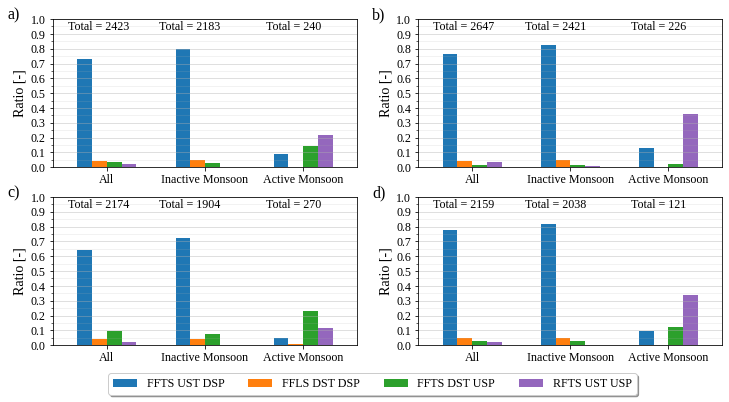

In [92]:
test_names = [
    'base', 'lower_conv_level', 'higher_conv_level', 'four_levels',
    'no_steiner', 'lower_ref_thresh', 'higher_shear_thresh', 'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'linear_50', 'linear_25', 'combined']

test_names = [
    'base', 'lower_conv_level', 
    'higher_conv_level', 'higher_shear_thresh']

fig, axes = plt.subplots(
    int(np.ceil(len(test_names)/2)), 2, figsize=(12, 6))

for i in range(len(test_names)):
# for i in [0]:

    base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/'
    class_path = base_dir + 'TINT_tracks/'
    class_path += '{}_classes.pkl'.format(test_names[i])

    with open(class_path, 'rb') as f:
        class_df = pickle.load(f)

    ratios_df = cl.monsoon_comparison(
        class_df, fig=fig, ax=axes.flatten()[i], legend=False)
            
#     fn = 'shear_breakdown_{}.png'.format(test_names[i])
#     plt.savefig(
#         fig_dir + fn, dpi=200, facecolor='w',
#         edgecolor='white', bbox_inches='tight')

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.05, -0.375),
    ncol=4, fancybox=True, shadow=True)

cl.make_subplot_labels(axes.flatten())

fn = 'monsoon_breakdown_base_lower_higher_ref_higher_shear.png'.format(test_names[i])
plt.savefig(
    fig_dir + fn, dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

# Calculate Some Statistics

In [295]:
offset_sensitivity_df = pd.DataFrame({
    'Test': test, 'Trailing Stratiform': TS, 
    'Leading Stratiform': LS, 'Parallel Stratiform (Left)': LeS,
    'Parallel Stratiform (Right)': RiS, 'Total': total})

## System Size

In [260]:
[t/totals[-1]*100 for t in totals]

[counts    70.297463
 dtype: float64,
 counts    5.708661
 dtype: float64,
 counts    8.420822
 dtype: float64,
 counts    15.573053
 dtype: float64,
 counts    100.0
 dtype: float64]

In [301]:
inflow_sensitivity_df

,Test,Front Fed,Rear Fed,Parallel Fed (Left),Parallel Fed (Right),Ambiguous,Total
0,Base,2661,350,536,235,790,4572


In [7]:
# subset_logic = ~small_area
# sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [287]:
sensitivity_df.set_index('Test')

,Trailing Stratiform,Leading Stratiform,Parallel Stratiform (Left),Parallel Stratiform (Right),Total
Test,,,,,
Base,3214,261,385,712,4572


In [264]:
[t/totals[-1]*100 for t in totals]

[counts    70.297463
 dtype: float64,
 counts    5.708661
 dtype: float64,
 counts    8.420822
 dtype: float64,
 counts    15.573053
 dtype: float64,
 counts    100.0
 dtype: float64]

In [14]:
# Create 3 lists with lengths the lifetime of longest object.
[large, small, medium, nb, totals] = [np.zeros(100) for i in range(5)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
    
#     import pdb
#     pdb.set_trace()
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = categories.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    large_area = cat['large_area'].values
    small_area = cat['small_area'].values
    medium_area = ~large_area & ~small_area
    not_border = cat['not_border'].values | cat['not_border_0'].values
    
    large_inds = scan_label[large_area]
    medium_inds = scan_label[medium_area]
    small_inds = scan_label[small_area]
    not_border_inds = scan_label[not_border]
    totals_inds = scan_label.tolist()
    
    # Break down sig_tilt categories
#     forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
#     backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

#     fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
#     bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
#     pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        large[large_inds] += 1
        small[small_inds] += 1
        medium[medium_inds] += 1
        nb[not_border_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 25948/25948 [02:18<00:00, 186.83it/s]


In [298]:
inflow_sensitivity_df = pd.DataFrame({
    'Test': test, 'Front Fed': FF, 
    'Rear Fed': RF, 'Parallel Fed (Left)': LeF,
    'Parallel Fed (Right)': RiF, 'Total': total})

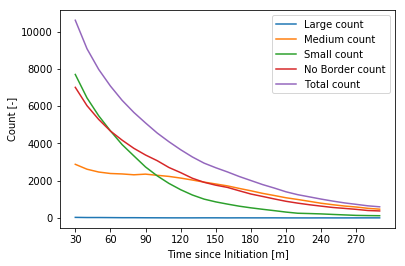

In [17]:
plt.plot(np.arange(30,300,10), large[3:30], label='Large count')
plt.plot(np.arange(30,300,10), medium[3:30], label='Medium count')
plt.plot(np.arange(30,300,10), small[3:30], label='Small count')
plt.plot(np.arange(30,300,10), nb[3:30], label='No Border count')
plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

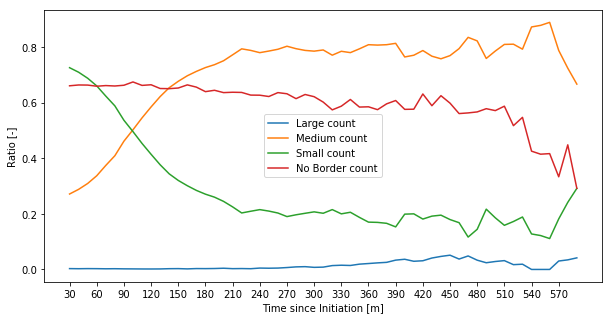

In [22]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(30,600,10), (large/totals)[3:60], label='Large count')
plt.plot(np.arange(30,600,10), (medium/totals)[3:60], label='Medium count')
plt.plot(np.arange(30,600,10), (small/totals)[3:60], label='Small count')
plt.plot(np.arange(30,600,10), (nb/totals)[3:60], label='No Border count')
plt.xticks(np.arange(30,600,30))
plt.ylabel('Ratio [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
# Note that we don't really know the start times of the systems!
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_ratios.png')

## Training Lines

In [12]:
subset_logic = (categories['not_border'] & categories['not_border_0']
                & ~categories['large_area'] & ~categories['small_area'] 
                & categories['linear'] & ~categories['stationary']
                & categories['sig_vel_mag'])
sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_cat = categories[subset_logic]
# sub_tracks = tracks_obj.system_tracks
# sub_cat = categories

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2])
                            for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [13]:
# Create 3 lists with lengths the lifetime of longest object.
[par, perp, totals] = [np.zeros(100) for i in range(3)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
       
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = sub_cat.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    perp_align = cat['perp_align'].values
    par_align = cat['par_align'].values
        
    par_inds = scan_label[par_align]
    perp_inds = scan_label[perp_align]
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        par[par_inds] += 1
        perp[perp_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 91/91 [00:00<00:00, 170.20it/s]


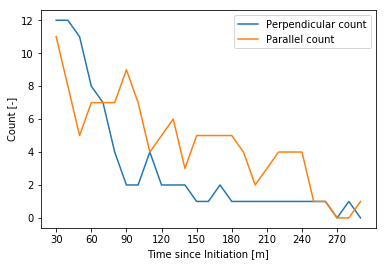

In [14]:
plt.plot(np.arange(30,300,10), perp[3:30], label='Perpendicular count')
plt.plot(np.arange(30,300,10), par[3:30], label='Parallel count')
# plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

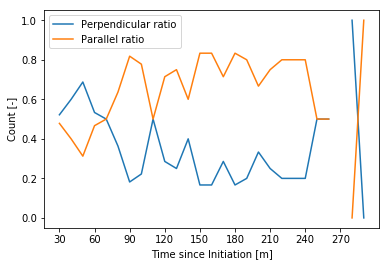

In [15]:
plt.plot(np.arange(30,300,10), (perp/totals)[3:30], label='Perpendicular ratio')
plt.plot(np.arange(30,300,10), (par/totals)[3:30], label='Parallel ratio')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

## Updraft Tilt versus Stratiform Tilt

In [29]:
def calc_mean_max_updrafts(system_tracks, min_height_ind = 20):
    ud = system_tracks['updrafts']
    ud_tilt = []
    tallest_ud = []
    mean_ud = []
    no_tilt=0
    for i in range(len(ud)):
        ud_i = ud.iloc[i]
        ud_tilt_i = []
        for j in range(len(ud_i)):
            if ud_i[j][-1][0] >= min_height_ind:
                ud_tilt_i_j = (ud_i[j][-1]-ud_i[j][0])*(.5, 2.5, 2.5)
                if np.all(ud_tilt_i_j[1:3] == [0,0]):
                    # Count updrafts with no tilt seperately
                    no_tilt+=1
                else:
                    ud_tilt_i.append(ud_tilt_i_j)
       
        if ud_tilt_i != []:
            ud_tilt.append(ud_tilt_i)
            mean_ud.append(np.nanmean(np.array(ud_tilt_i), axis=0))
        else:
            ud_tilt.append(np.ones(3)*np.nan)
            mean_ud.append(np.ones(3)*np.nan)
        try:
            tallest_ind = np.argmax(np.array(ud_tilt_i)[:,0])
            tallest_ud.append(np.array(ud_tilt_i)[tallest_ind,:])
        except:
            tallest_ud.append(np.ones(3)*np.nan)
        
    return ud_tilt, mean_ud, tallest_ud

### Tallest Updraft

In [155]:
q_str = "(offset_type == 'Trailing Stratiform'"
q_str += "and inflow_type == 'Front Fed')"
q_str += "or (offset_type == 'Leading Stratiform'"
q_str += "and inflow_type == 'Rear Fed')"
q_str += "or (offset_type == 'Parallel Stratiform (Left)'"
q_str += "and inflow_type == 'Parallel Fed (Right)')"
q_str += "or (offset_type == 'Parallel Stratiform (Right)'"
q_str += "and inflow_type == 'Parallel Fed (Left)')"
TS = counts_df.query(q_str)

q_str = "(offset_type == 'Leading Stratiform'"
q_str += "and inflow_type == 'Front Fed')"
q_str += "or (offset_type == 'Trailing Stratiform'"
q_str += "and inflow_type == 'Rear Fed')"
q_str += "or (offset_type == 'Parallel Stratiform (Left)'"
q_str += "and inflow_type == 'Parallel Fed (Left)')"
q_str += "or (offset_type == 'Parallel Stratiform (Right)'"
q_str += "and inflow_type == 'Parallel Fed (Right)')"
LS = counts_df.query(q_str)

q_str = "(offset_type == 'Leading Stratiform'"
q_str += "and inflow_type == 'Parallel Fed (Right)')"
q_str += "or (offset_type == 'Trailing Stratiform'"
q_str += "and inflow_type == 'Parallel Fed (Left)')"
q_str += "or (offset_type == 'Parallel Stratiform (Left)'"
q_str += "and inflow_type == 'Front Fed')"
q_str += "or (offset_type == 'Parallel Stratiform (Right)'"
q_str += "and inflow_type == 'Rear Fed (Right)')"
LeS = counts_df.query(q_str)

q_str = "(offset_type == 'Leading Stratiform'"
q_str += "and inflow_type == 'Parallel Fed (Left)')"
q_str += "or (offset_type == 'Trailing Stratiform'"
q_str += "and inflow_type == 'Parallel Fed (Right)')"
q_str += "or (offset_type == 'Parallel Stratiform (Right)'"
q_str += "and inflow_type == 'Front Fed')"
q_str += "or (offset_type == 'Parallel Stratiform (Left)'"
q_str += "and inflow_type == 'Rear Fed')"
RiS = counts_df.query(q_str)

In [33]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(tallest_ud)
den = np.tile(np.array(tallest_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

In [149]:
3270.000000/(5944.000000/.80749898)

0.44423311988559894

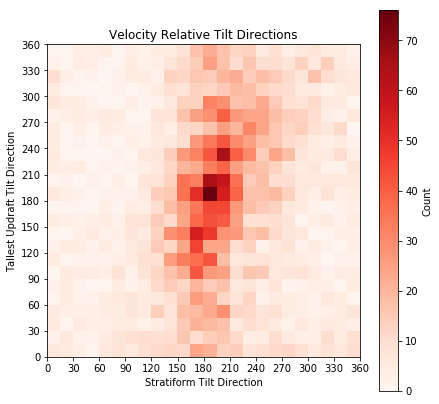

In [35]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Tallest Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')

### Mean Updraft

In [36]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(mean_ud)
den = np.tile(np.array(mean_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

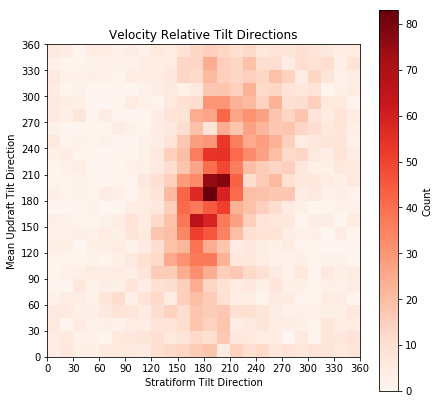

In [38]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Mean Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')

In [11]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

## Rain

In [9]:
uids = list(set([tracks_obj.system_tracks.index[i][2] for i in range(len(tracks_obj.system_tracks))]))

ratio = []
tot_rain = []

for u in uids:
    hours = len(tracks_obj.system_tracks.xs(u, level='uid'))*1/6
    r = categories.xs(u, level='uid')['par_align'].sum()/len(tracks_obj.system_tracks.xs(u, level='uid'))
    ratio.append(r)
    tot_rain.append(tracks_obj.system_tracks.xs(u, level='uid')['tot_rain'][-1])
# tracks_obj.system_tracks.xs('0', level='uid')['vel_dir']

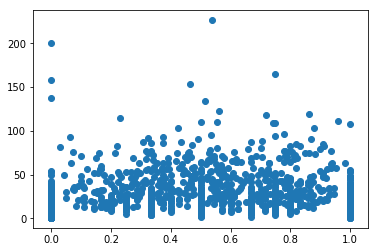

In [10]:
tot_rain = np.array(tot_rain)
tot_rain[tot_rain>500]=np.nan
plt.scatter(ratio, tot_rain)

In [73]:
sub_cat['par_align'].groupby(level='uid').sum().sort_values(ascending=False)[:20]

Series([], Name: par_align, dtype: bool)

In [ ]:
## Rain

uids = list(set([tracks_obj.system_tracks.index[i][2] for i in range(len(tracks_obj.system_tracks))]))

ratio = []
tot_rain = []

for u in uids:
    hours = len(tracks_obj.system_tracks.xs(u, level='uid'))*1/6
    r = categories.xs(u, level='uid')['par_align'].sum()/len(tracks_obj.system_tracks.xs(u, level='uid'))
    ratio.append(r)
    tot_rain.append(tracks_obj.system_tracks.xs(u, level='uid')['tot_rain'][-1])
# tracks_obj.system_tracks.xs('0', level='uid')['vel_dir']

tot_rain = np.array(tot_rain)
tot_rain[tot_rain>500]=np.nan
plt.scatter(ratio, tot_rain)

sub_cat['par_align'].groupby(level='uid').sum().sort_values(ascending=False)[:20]